<font size="+3"><strong>5.4. Gradient Boosting Trees</strong></font>

You've been working hard, and now you have all the tools you need to build and tune  models. We'll start this lesson the same way we've started the others: preparing the data and building our model, and this time with a new ensemble model. Once it's working, we'll learn some new performance metrics to evaluate it. By the end of this lesson, you'll have written your first Python module!  

In [4]:
import gzip
import json
import pickle
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

from scipy.io.arff import loadarff  # Import loadarff
from sklearn.ensemble import GradientBoostingClassifier




# Prepare Data

In [5]:
def wrangle(filename):
    # Load ARFF file
    data, meta = loadarff(filename)
    
    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Rename columns
    df.columns = [re.sub(pattern='Attr',repl='feat_',string=col) for col in df.columns]
    df.rename(columns={'class':'bankrupt'},inplace=True)
    
    # Change dtype of the Labels columns
    df['bankrupt'] = df['bankrupt'].astype(np.int64)

    return df

In [6]:
df = wrangle("../data/raw/3year.arff")
print(df.shape)
df.head()

(10503, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,0
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,0
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,0
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,...,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,0
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,0


**Task 5.4.2:** Create your feature matrix `X` and target vector `y`. Your target is `"bankrupt"`. 


In [7]:
target = "bankrupt"
X = df.drop(columns="bankrupt")
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10503, 64)
y shape: (10503,)


**Task 5.4.3:** Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility. 


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8402, 64)
y_train shape: (8402,)
X_test shape: (2101, 64)
y_test shape: (2101,)


**Task 5.4.4:** Create a new feature matrix `X_train_over` and target vector `y_train_over` by performing random over-sampling on the training data.


In [9]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (16028, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.013739,0.48424,0.335830,3.28400,28.116,0.00000,0.017206,1.0651,1.36290,0.51576,...,5550.80,0.014543,0.026638,0.98749,0.000000,5.8807,5.7658,39.379,9.2689,2.6354
1,0.055586,0.28747,0.340460,2.21220,41.783,0.15219,0.065999,2.1786,0.92951,0.62626,...,5034.80,-0.075836,0.088758,1.07580,0.010533,11.7840,5.4632,62.549,5.8354,4.3283
2,0.125190,0.21204,-0.043561,0.76704,-26.932,0.42740,0.155220,3.7142,1.17620,0.78757,...,-5127.20,0.149790,0.158960,0.85021,0.031808,68.9750,10.7120,63.477,5.7501,1.2553
3,0.271490,0.34761,0.419280,2.24250,300.000,0.12908,0.303200,1.8768,8.68160,0.65239,...,1322.00,0.038724,0.416140,0.98078,0.000000,147.9600,149.5800,14.188,25.7270,35.6880
4,0.485420,0.38138,0.618620,2.62200,372.120,0.00000,0.596450,1.6220,2.96690,0.61862,...,490.72,0.200640,0.784690,0.81596,0.000000,NaN,4.2876,46.919,7.7793,NaN


**Task 5.4.5:** Calculate the baseline accuracy score for your model.


In [10]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9538


**Task 5.4.6:** Create a pipeline named `clf` (short for "classifier") that contains a `SimpleImputer` transformer and a `GradientBoostingClassifier` predictor.


In [11]:
clf = make_pipeline(SimpleImputer(), GradientBoostingClassifier())

**Task 5.4.7:** Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier. 

In [12]:
params = {
    "simpleimputer__strategy": ["mean", "median"],
    "gradientboostingclassifier__n_estimators": range(20, 31, 5),
    "gradientboostingclassifier__max_depth": range(2, 5)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

**Task 5.4.8:** Create a `GridSearchCV` named `model` that includes your classifier and hyperparameter grid. Be sure to use the same arguments for `cv` and `n_jobs` that you used above, and set `verbose` to 1. 


In [13]:
model = GridSearchCV(clf, param_grid=params, cv=5, n_jobs=-1, verbose=1)

**Task 5.4.9:** Fit your `model` to the over-sampled training data.

In [14]:
# Fit model to over-sampled training data
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

**Task 5.4.10:** Extract the cross-validation results from `model` and load them into a DataFrame named `cv_results`.


In [15]:
results = pd.DataFrame(model.cv_results_)
results.sort_values("rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,13.480216,1.578589,0.013447,0.009006,4,30,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.913911,0.913600,0.904866,0.909516,0.920749,0.912528,0.005262,1
14,13.181766,3.175304,0.014519,0.011118,4,25,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.905802,0.912352,0.897692,0.894540,0.904212,0.902919,0.006269,2
17,11.130379,1.728650,0.010546,0.002241,4,30,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.904242,0.908609,0.901747,0.897660,0.902028,0.902857,0.003576,3
12,10.984624,1.619207,0.019109,0.012038,4,20,mean,"{'gradientboostingclassifier__max_depth': 4, '...",0.895197,0.892077,0.890830,0.882683,0.893292,0.890816,0.004314,4
15,11.844182,2.391750,0.017354,0.007209,4,25,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.896132,0.893013,0.885527,0.884555,0.888924,0.889630,0.004400,5
13,10.453986,1.892961,0.013048,0.004419,4,20,median,"{'gradientboostingclassifier__max_depth': 4, '...",0.878041,0.880225,0.868684,0.867707,0.875195,0.873970,0.004987,6
10,10.312088,1.349846,0.014634,0.005838,3,30,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.879913,0.878353,0.874298,0.863339,0.873323,0.873845,0.005797,7
8,8.931799,1.744207,0.016344,0.009854,3,25,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.866500,0.865876,0.860574,0.854602,0.858034,0.861117,0.004558,8
11,10.533055,1.341281,0.015665,0.006981,3,30,median,"{'gradientboostingclassifier__max_depth': 3, '...",0.855895,0.862445,0.851840,0.854914,0.845866,0.854192,0.005411,9
6,6.115572,0.956377,0.013010,0.010076,3,20,mean,"{'gradientboostingclassifier__max_depth': 3, '...",0.857767,0.850593,0.854336,0.844306,0.852418,0.851884,0.004472,10


**Task 5.4.11:** Extract the best hyperparameters from `model`.


In [16]:
# Extract best hyperparameters
model.best_estimator_

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=4, n_estimators=30))])

**Task 5.4.12:** Calculate the training and test accuracy scores for `model`. 


In [17]:
acc_train = ...
acc_test = ...

acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9056
Validation Accuracy: 0.8891


**Task 5.4.13:** Plot a confusion matrix that shows how your best model performs on your test set. 


**Task 5.4.14:** Print the classification report for your model, using the test set.


In [18]:
# Print classification report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1994
           1       0.28      0.76      0.41       107

    accuracy                           0.89      2101
   macro avg       0.63      0.83      0.67      2101
weighted avg       0.95      0.89      0.91      2101



**Task 5.4.15:** Run the cell below to load the confusion matrix widget.


In [19]:
model.predict(X_test)[:5]

array([0, 1, 0, 0, 0])

In [20]:
model.predict_proba(X_test)

array([[0.55520172, 0.44479828],
       [0.49294714, 0.50705286],
       [0.84459943, 0.15540057],
       ...,
       [0.85505238, 0.14494762],
       [0.39339254, 0.60660746],
       [0.89244496, 0.10755504]])

In [21]:
c = ConfusionMatrixWidget(model, X_test, y_test)
c.show()

NameError: name 'ConfusionMatrixWidget' is not defined

**Task 5.3.16:** Plot a confusion matrix that shows how your best model performs on your test set. 


In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

NameError: name 'model' is not defined

**Task 5.3.17:** Create a horizontal bar chart with the 10 most important features for your model. 

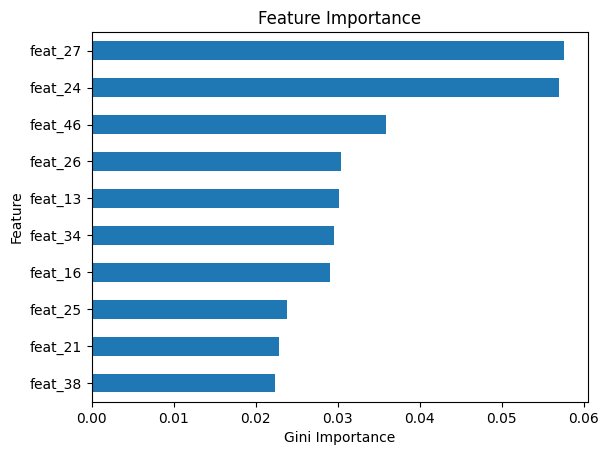

In [ ]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind = "barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

**Task 5.3.18:** Using a context manager, save your best-performing model to a a file named `"model-5-3.pkl"`. 


In [ ]:
# Save model
with open("model-5-3.pkl", "wb") as f:
    pickle.dump(model, f)

**Task 5.3.19:** Create a function `make_predictions`. It should take two arguments: the path of a JSON file that contains test data and the path of a serialized model. The function should load and clean the data using the `wrangle` function you created, load the model, generate an array of predictions, and convert that array into a Series. (The Series should have the name `"bankrupt"` and the same index labels as the test data.) Finally, the function should return its predictions as a Series. 


In [ ]:
def make_predictions(data_filepath, model_filepath):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)
    # Load model
    with open(model_filepath, "rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index=X_test.index, name="bankrupt")
    return y_test_pred

**Task 5.3.20:** Use the code below to check your `make_predictions` function. Once you're satisfied with the result, submit it to the grader. 

In [ ]:
y_test_pred = make_predictions(
    data_filepath="../data/raw/3year.arff",
    model_filepath="model-5-3.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()